In [1]:
from pathlib import Path
import pandas as pd
import seaborn as sns
from pybedtools import BedTool

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, PrecisionRecallDisplay

from scipy.spatial.distance import pdist, squareform

import numpy as np
from scipy import stats
import matplotlib.cm as cm
import matplotlib
import math
from plot_params import *
basedir= Path('/home/hsher/scratch/ABC_2rep/')
out_stem = 'K562_rep6'

In [2]:
ground_truth = pd.read_csv('Dan_multiplex1_K562_rep4.Dan_multiplex1_K562_rep6.reproducible_window.csv',
                          index_col = 0)
clipper_1rep = pd.read_csv(f'Dan_multiplex1_{out_stem}.window.csv')
ground_truth_skipper = pd.read_csv('ABC_K562.skipper_reproducible_window.csv',
                          index_col = 0)
ground_truth_skipper.rename({'DDX3X':'DDX3'}, axis = 1, inplace = True)
ground_truth_skipper.sum().sort_values()

EIF3G         213
ZC3H11A      4722
PUM2         7147
RBFOX2      12206
DDX3        12334
LIN28B      26668
IGF2BP2     28834
SF3B4       44025
FAM120A     50622
PRPF8      102243
dtype: int64

In [3]:
data = pd.read_csv(basedir/f'DMM/{out_stem}.mixture_weight.tsv', sep = '\t', index_col = 0)
data.set_index('Row.names', inplace = True)

In [4]:
mixture_weight_only = data.loc[:, data.columns.str.startswith('V')]
mixture_weight_only.columns
data['cluster']=mixture_weight_only.idxmax(axis = 1)

In [5]:
mapstat = pd.read_csv(basedir/'QC/mapping_stats.csv')
mapstat = mapstat.loc[mapstat['STAR Log filename'].str.contains(out_stem)]
mapstat['name'] = mapstat['STAR Log filename'].apply(lambda x: x.split('/')[-1].split('.')[0])
mapstat.set_index('name', inplace = True)
mapstat['total_mapped_reads'] = mapstat['Uniquely mapped reads number']+mapstat['Number of reads mapped to multiple loci']

In [6]:
raw_data = pd.read_csv(basedir /f'counts/genome/megatables/{out_stem}.tsv.gz', sep = '\t')
raw_data = raw_data.loc[raw_data.sum(axis = 1)>10]
raw_data.index = raw_data.index+1

In [7]:

weights = pd.read_csv(basedir/f'DMM/{out_stem}.weights.tsv', sep = '\t', index_col = 0)
weights.index = [f'V{i}' for i in weights.index]

In [8]:
megaoutput = pd.read_csv(basedir/f'DMM/{out_stem}.megaoutputs.tsv', sep = '\t', index_col = 0)

In [9]:
anno = pd.read_csv(basedir/f'DMM/{out_stem}.cluster_annotation_binary.csv',
                          index_col = 0) # RBP by components, B * K

In [10]:
# apply mask to BBM, skipper and Piranha in place, not integrated into pipeline yet
mask = pd.read_csv(basedir / f'mask/{out_stem}.genome_mask.csv', index_col = 0) 
mask.columns = [c.split('.')[1] for c in mask.columns]

# Comparing binding site counts
- different algorithm
- different backgrounds

In [11]:
# initial published data
clipper_counts = pd.read_csv(f'Dan_multiplex1_{out_stem}.window.feature_counts.csv', index_col = 0).T
clipper_counts['name']='CLIPper+CC'
clipper_counts['RBP']=clipper_counts.index
# eCLIP reproducible windows
eclip_counts = pd.read_csv('ABC_K562.skipper_reproducible_window.feature_counts.csv', index_col = 0).T
eclip_counts.rename({'DDX3X':'DDX3'}, inplace = True)
eclip_counts['name']='eCLIP'
eclip_counts['RBP']=eclip_counts.index

In [12]:
def count_beta_mixture(root_dir, name):
    all_counts = []
    for fname in list(root_dir.glob(f'{out_stem}*enriched_windows.tsv')):
        libname, rbp = fname.name.split('.')[:2]
        df = pd.read_csv(fname, index_col = 0, sep = '\t')
        to_mask = mask.loc[~mask[f'{rbp}']].index # False mean the deviation zscore is not high enough
        df = df.loc[~df['name'].isin(to_mask)]
        cnt = df['feature_type_top'].value_counts()
        cnt['RBP'] = rbp

        all_counts.append(cnt)
    all_counts = pd.concat(all_counts, axis = 1).fillna(0).sort_index().T
    all_counts['name']=name
    return all_counts

In [13]:
def get_piranha_count(root_dir, name):
    count = []
    for f in list(root_dir.glob(f'{out_stem}*')):
        piranha_df = pd.read_csv(f, names = ['chr', 'start', 'end', 'name', 'score', 'strand', 'pval', 'cov'], sep = '\t')
        rbp = f.name.split('.')[1]
        to_mask = mask.loc[~mask[f'{rbp}']].index
        piranha_df['feature_type_top']=piranha_df['name'].map(data['feature_type_top'])
        cnt = piranha_df.loc[~piranha_df['name'].isin(to_mask), 'feature_type_top'].value_counts()
        cnt['RBP'] = rbp
        count.append(cnt)
    count = pd.concat(count, axis = 1).T
    count['name']=name
    return count

In [14]:
def get_skipper_count(root_dir, name):
    reg_col = ['CDS', 'INTRON', 'UTR3', 'UTR5', 'CDS_START', 'SS5_PROX', 'EXON_LNCRNA',
       'EXON_MRNA', 'CDS_STOP', 'SS5_ADJ', 'SS3_PROX', 'EXON_SMALL',
       'SSB_PROX', 'SS3_ADJ', 'PRIMIRNA', 'EXON_PSEUDO', 'SSB_ADJ',
       'CDS_SOLITARY']
    counts = []
    for paths in (root_dir/'enriched_windows').glob(f'{out_stem}.*enriched_windows*'):
        df = pd.read_csv(paths, sep='\t')
        rbp = paths.name.split('.')[1]
        to_mask = mask.loc[~mask[f'{rbp}']].index
        
        # filter for significant
        df = df.loc[~df['name'].isin(to_mask)]
        region_count = df['feature_type_top'].value_counts()
        region_count['RBP']=paths.name.split('.')[1]
        
        counts.append(region_count)
    counts = pd.concat(counts, axis = 1).fillna(0).T
    counts['name']=name
    return counts


In [15]:
all_counts = [eclip_counts,
              count_beta_mixture((basedir/'DMM'), 'DMM'),
              count_beta_mixture((basedir/'beta-mixture_CC'), 'BBM+CC'),
              clipper_counts,
              get_skipper_count(basedir/'skipper_CC', 'Skipper+CC'),
              get_piranha_count(basedir/'comparison'/'piranha'/'CC', 'Piranha+CC')
              
             ]
for ext_background in ['K562_totalRNAseq', 'eCLIP_SLBP_SMInput', 
                       'oligoCLIP_IgG_rep1', 'oligoCLIP_ctrlBead_rep1',
                       'oligoCLIP_ctrlSpike_rep1']:
    all_counts.append(count_beta_mixture(basedir/f'beta-mixture_external/{ext_background}', 
                                         f'BBM+{ext_background}'))
    
    all_counts.append(get_skipper_count(basedir/'skipper_external'/ext_background, 
                                        f'skipper+{ext_background}'))
all_counts = pd.concat(all_counts, axis = 0).T.sort_index().T


In [16]:
def plot_feature_type_barplots(all_counts):
    sns.set_palette('tab20c')
    f, axes = plt.subplots(2,5, figsize = (10,4), sharey = True)
    axes = axes.flatten(order = 'C')
    i = 0
    for rbp, group in all_counts.groupby(by = 'RBP'):
        group.set_index('name').plot.barh(stacked = True, ax = axes[i], legend = False)
        axes[i].set_title(rbp)
        if i>=5:
            axes[i].set_xlabel('#enriched windows')
        i+=1
    axes[-1].legend(bbox_to_anchor = (1, -0.3), ncol = 5)
    sns.despine()
    plt.tight_layout(pad = 1)
    plt.subplots_adjust(
                        hspace=0.4)



In [17]:
def plot_ascertained_feature(counts):
    f, axes = plt.subplots(2,5, figsize = (10,4), sharey = True)
    axes = axes.flatten()

    feature = {'SF3B4': 'SS3', 
               'IGF2BP2': 'UTR3', 
               'RBFOX2': 'INTRON', 
               'EIF3G': 'UTR5', 
               'FAM120A': 'UTR3', 
               'DDX3': 'UTR5', 
               'LIN28B': 'UTR3',
               'PUM2': 'UTR3', 
               'PRPF8': 'SS5', 
               'ZC3H11A': 'UTR3'
              }
    truth_count = []
    for i, (rbp, ax) in enumerate(zip(counts['RBP'].unique(), axes)):
        feat = feature[rbp]
        presumed_truth = counts.loc[counts['RBP']==rbp].set_index('name')[counts.columns[counts.columns.str.contains(feat)]
                                                          ].sum(axis = 1)
        presumed_truth.plot.barh(ax = ax, color = 'Grey')
        ax.set_title(f'{rbp}:{feat}')
        if i>=5:
            ax.set_xlabel('#enriched windows')
        i+=1

        presumed_truth.name = rbp
        truth_count.append(presumed_truth)
    truth_count = pd.concat(truth_count, axis = 1)
    sns.despine()
    plt.tight_layout(pad = 1)
    plt.subplots_adjust(
                        hspace=0.4)

/scratch/hsher/33712418.tscc-mgr7.local/ipykernel_6333/4162475378.py:14: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(pad = 1)


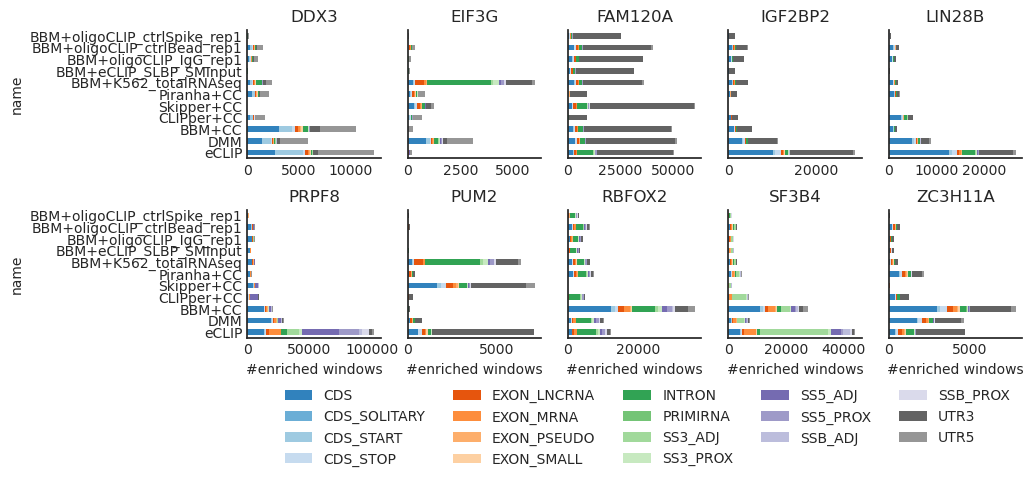

In [18]:
plot_feature_type_barplots(all_counts.loc[#(all_counts['name'].str.contains('BBM'))|
                                         (all_counts['name'].str.contains('DMM')) |
                                        (all_counts['name'].str.contains('BBM')) |
                                        (all_counts['name']=='eCLIP') |
                                        (all_counts['name']=='CLIPper+CC') |
                                        (all_counts['name']=='Skipper+CC') |
                                        (all_counts['name']=='Piranha+CC')
                                         ])
plt.savefig(figdir/f'feature_bar.pdf')

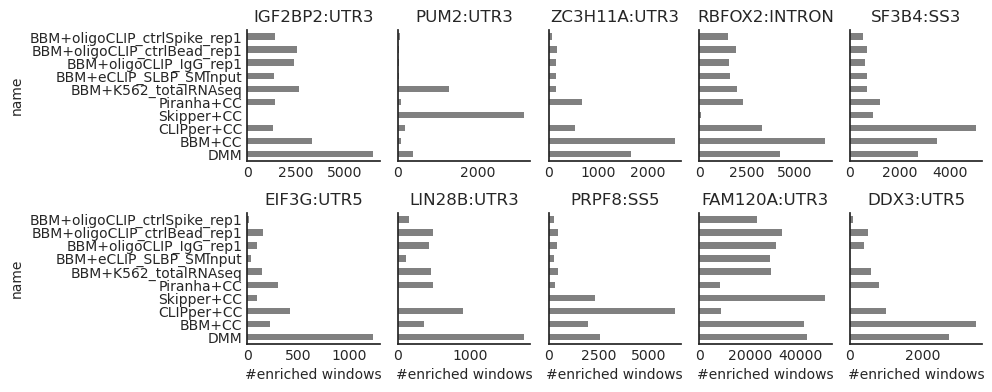

In [19]:
plot_ascertained_feature(all_counts.loc[(all_counts['name'].str.contains('DMM')) |
                                        (all_counts['name'].str.contains('BBM')) |
                                        
                                        (all_counts['name']=='CLIPper+CC') |
                                        (all_counts['name']=='Skipper+CC') |
                                        (all_counts['name']=='Piranha+CC')
                                         ])
plt.savefig(figdir/f'Ascertained_feature.pdf')

# Compare binding site classification to eCLIP
## Read all scores


In [20]:
all_scores = {}

In [21]:
def get_mixture_score_by_rbp(cluster_assignment_df,data):
    ''' sum up mixture score by belonging to a RBP or not '''
    mixture_score_by_rbp = []
    for rbp in cluster_assignment_df:
        clusters_belong_to_rbp = cluster_assignment_df[rbp].loc[cluster_assignment_df[rbp]].index
        rbp_score = data[clusters_belong_to_rbp].sum(axis = 1)
        rbp_score.name = rbp.split('.')[1]
        mixture_score_by_rbp.append(rbp_score)
    mixture_score_by_rbp = pd.concat(mixture_score_by_rbp, axis = 1)
    return mixture_score_by_rbp

In [22]:
all_scores['DMM']=get_mixture_score_by_rbp(anno, data)

In [23]:
def read_piranha_pv(root_dir):
    ''' given root_dir, return `1-pvalue` from Piranha outputs '''
    
    scores = []
    for f in list(root_dir.glob(f'{out_stem}*')):
        piranha_df = pd.read_csv(f, 
                                 names = ['chr', 'start', 'sned', 'name', 'score', 'strand', 'pval', 'cov'], sep = '\t')
        
        values = 1-piranha_df.set_index('name')['pval']
        values.name = f.name.split('.')[1]
        scores.append(values)
        
    scores = pd.concat(scores, axis = 1)
    
    # global: all windows with read > 10
    scores = scores.merge(data['cluster'], 
                          left_index = True, 
                          right_index = True, how = 'right').fillna(0).drop('cluster', axis = 1)
    return scores

In [24]:
all_scores['Piranha+CC']=read_piranha_pv(basedir/'comparison'/'piranha'/'CC')

In [25]:
def read_BBM_scores(root_dir):
    ''' given root_dir, return logLR scores or 1-pvalue '''
    
    window_score = []
    for f in list((root_dir).glob(f'{out_stem}*window_score.tsv')):
        
        rbp = f.name.split('.')[1]
        full_scores = pd.read_csv(f
                                  , sep = '\t').set_index('name')
        if 'logLR' in full_scores.columns:
            score = full_scores['logLR']
        else:
            score = 1-full_scores['pvalue']
        score.name = rbp
        window_score.append(score)
    
    scores = pd.concat(window_score, axis = 1)
    
    # global: all windows with read > 10
    scores = scores.merge(data['cluster'], 
                          left_index = True, 
                          right_index = True, how = 'right').fillna(0).drop('cluster', axis = 1)
    
    return scores



In [26]:
all_scores['BBM+CC'] = read_BBM_scores(basedir/'beta-mixture_CC')
for ext_background in ['K562_totalRNAseq', 'eCLIP_SLBP_SMInput', 
                       'oligoCLIP_IgG_rep1', 'oligoCLIP_ctrlBead_rep1',
                       'oligoCLIP_ctrlSpike_rep1']:
    all_scores[f'BBM+{ext_background}']=read_BBM_scores(basedir/f'beta-mixture_external/{ext_background}')

In [27]:
# CLIPper
clipper_pv = pd.read_csv(f'Dan_multiplex1_{out_stem}.best_pval_perwindow.csv', index_col = 0)
all_scores['CLIPper+CC(p-value)'] = clipper_pv.merge(data['cluster'], left_index = True, right_index = True, how = 'right').drop('cluster', axis = 1).fillna(0) # some had missing windows, no clipper peaks. fill w 0
clipper_fc = pd.read_csv(f'Dan_multiplex1_{out_stem}.best_fc_perwindow.csv', index_col = 0)
all_scores['CLIPper+CC(FC)'] = clipper_fc.merge(data['cluster'], left_index = True, right_index = True, how = 'right').drop('cluster', axis = 1).fillna(0)



In [28]:
# make sure they are of the same shape
ground_truth_skipper10reads = ground_truth_skipper.loc[ground_truth_skipper.index.isin(data.index)]
all_scores['eCLIP'] = ground_truth_skipper10reads.merge(data, left_index = True, right_index = True, how = 'right')[ground_truth_skipper.columns].fillna(False)

## Test per hypothesis
- combinatorial benchmarking

In [29]:
def collapsed_gold_standard(cluster_assignment_df, ground_truth_skipper):
    '''
    generate gold standard per hypothesis (type of label)
    returns:
        gold_collapse: collapsed goldstandard per hypothesis
        collapsed_cluster: dict, hypothesis -> component
        collapsed_cluster_anno: dict, hypothesis -> RBPs that are positive
    '''
    cluster_gold_standard_collapsed = []
    collapsed_cluster = {}
    collapsed_cluster_annot = {}

    id_ = 0
    for name, group in cluster_assignment_df.groupby(by = cluster_assignment_df.columns.tolist()):
        columns = group.columns[group.sum(axis = 0)>0]
        if len(columns) > 0:
            cluster_ids = group.index
            collapsed_cluster[id_]=cluster_ids

            columns = group.columns[group.sum(axis = 0)>0]

            rbps = [r.split('.')[1] for r in
                    columns]
            collapsed_cluster_annot[id_]=rbps
            truth = (ground_truth_skipper[rbps].all(axis = 1))&(ground_truth_skipper.sum(axis = 1).eq(len(rbps)))

            truth.name = id_
            cluster_gold_standard_collapsed.append(truth)
            id_ += 1
    cluster_gold_standard_collapsed = pd.concat(cluster_gold_standard_collapsed, axis = 1)
    cluster_gold_standard_collapsed[cluster_gold_standard_collapsed.sum(axis = 0).sort_values(ascending = False).index]
    return cluster_gold_standard_collapsed, collapsed_cluster, collapsed_cluster_annot

In [30]:
def collapsed_posterior(data, collapsed_cluster):
    ''' sum of posterior P(is cluster | data) for cluster of the same type of hypothesis '''
    collapsed_data = []
    for hypothesis in collapsed_cluster.keys():
        sum_score = data[collapsed_cluster[hypothesis]].sum(axis = 1)
        sum_score.name = hypothesis
        collapsed_data.append(sum_score)
    return pd.concat(collapsed_data, axis = 1)

In [31]:
all_scores.keys()

dict_keys(['DMM', 'Piranha+CC', 'BBM+CC', 'BBM+K562_totalRNAseq', 'BBM+eCLIP_SLBP_SMInput', 'BBM+oligoCLIP_IgG_rep1', 'BBM+oligoCLIP_ctrlBead_rep1', 'BBM+oligoCLIP_ctrlSpike_rep1', 'CLIPper+CC(p-value)', 'CLIPper+CC(FC)', 'eCLIP'])

In [32]:
all_score_by_hypothesis = {}
all_score_by_hypothesis['eCLIP'], collapsed_cluster, collapsed_cluster_anno = collapsed_gold_standard(anno, all_scores['eCLIP'])
all_score_by_hypothesis['DMM'] = collapsed_posterior(data, collapsed_cluster)
for name in all_scores.keys():
    if name != 'DMM' and name !='eCLIP':
        all_score_by_hypothesis[name] = collapsed_posterior(all_scores[name], collapsed_cluster_anno)
        

In [33]:
# common index
def collapsed_auprc(all_score_by_hypothesis, 
                    collapsed_cluster, 
                    collapsed_cluster_annot,
                   goldstandard_key = 'eCLIP'):
    auprc_data = []
    ground_truth = all_score_by_hypothesis[goldstandard_key]
    
    # plot ROC curve
    f, axes = plt.subplots(4, int(ground_truth.shape[1]/4), figsize = (12,8))
    axes = axes.flatten()
    
    for col, ax in zip(ground_truth.columns, axes):
        
        clusters_ids = collapsed_cluster[col]
        rbps = collapsed_cluster_annot[col]
        rbp_str = ','.join(rbps)
        
        truth = ground_truth[col]
        
        for name in all_score_by_hypothesis.keys():
            if name != goldstandard_key:
                
                score = all_score_by_hypothesis[name][col]
        
                # DMM
                precision, recall, thresholds = precision_recall_curve(truth, 
                                                                        score)
                ax.plot(recall, precision, label = name)
                auprc = auc(recall, precision)

        
        
        
                ax.set_title(f'Hypothesis {col}\n({rbp_str})')
                ax.set_ylabel('Precision')
                ax.set_xlabel('Recall')

                auprc_data.append([col, rbp_str, auprc, name])
    ax.legend()
    sns.despine()
    
    return pd.DataFrame(auprc_data, columns=['Hypothesis No.', 'RBP', 'AUPRC', 'name'])

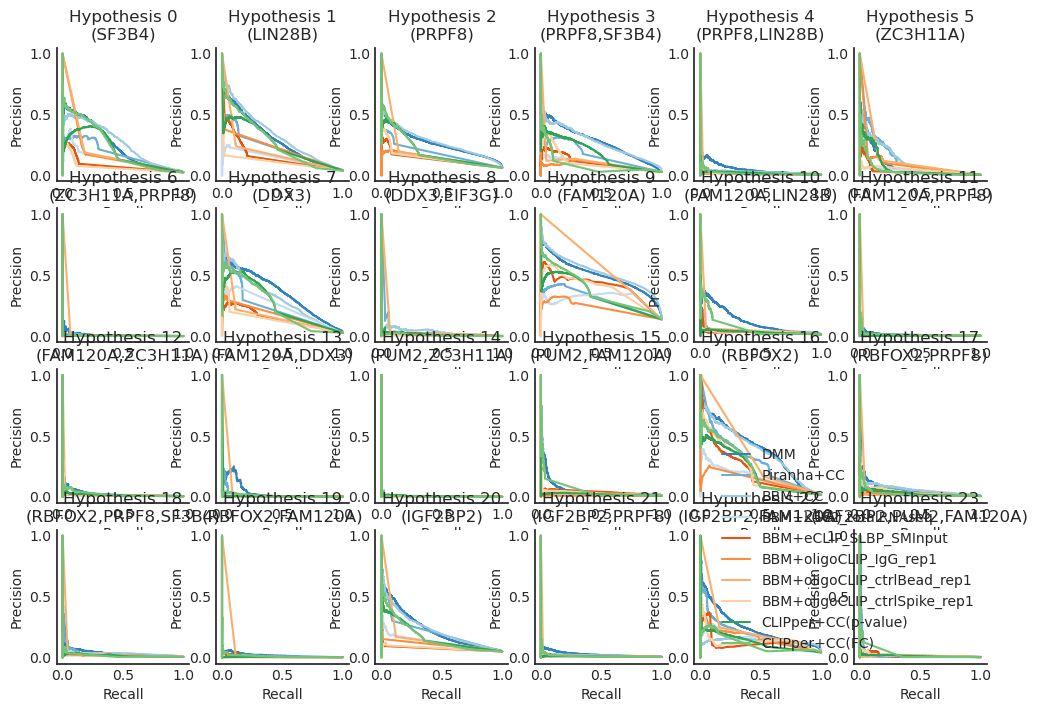

In [34]:
sns.set_palette('tab20c')
auprc_df = collapsed_auprc(all_score_by_hypothesis, collapsed_cluster, collapsed_cluster_anno)
plt.savefig(figdir/'Hypothesis_AUPRC.pdf')


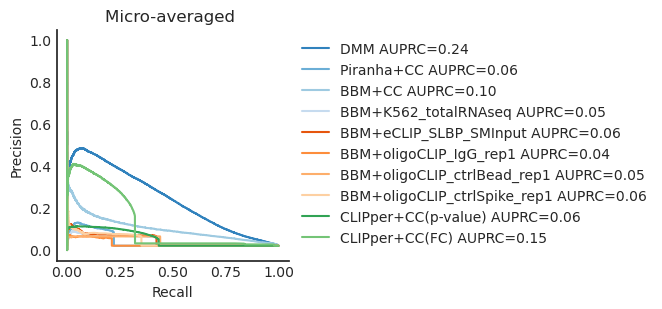

In [35]:
# microaverage precision recall


# For each class
Y_test = all_score_by_hypothesis['eCLIP']
precision = dict()
recall = dict()
average_precision = dict()
f, ax = plt.subplots(figsize = (3,3))

for name in all_score_by_hypothesis.keys():
    # A "micro-average": quantifying score on all classes jointly
    
    if name != 'eCLIP':
    
        y_score = all_score_by_hypothesis[name]
        precision["micro"], recall["micro"], _ = precision_recall_curve(
            Y_test.values.ravel(), y_score.values.ravel()
        )
        average_precision["micro"] = average_precision_score(
            Y_test, 
            y_score, average="micro")
        display = PrecisionRecallDisplay(
            recall=recall["micro"],
            precision=precision["micro"],
            average_precision=average_precision["micro"],
        )
        auprc = auc(recall["micro"], precision["micro"])
        display.plot(label = f'{name} AUPRC={auprc:.2f}', ax = ax)
        _ = display.ax_.set_title("Micro-averaged ")
ax.legend(bbox_to_anchor = (1, 1))
sns.despine()
plt.savefig(figdir/'Hypothesis_micro_AUPRC.pdf')

In [36]:
def pairwise_compare_AUPRC(auprc_df, col1, col2):
    auprc_df.plot.scatter(x = col1, y = col2,figsize = (3,3), color = 'grey')
    plt.plot([0,auprc_df['DMM'].max()],[0,auprc_df['DMM'].max()], '--', color = 'grey')
    for index, row in auprc_df.loc[(auprc_df[col1]-auprc_df[col2]).abs()>0.03].iterrows():
        plt.annotate(index,(row[col1], row[col2]),xytext=(row[col1]-0.06, row[col2]+0.03),
                    arrowprops=dict(arrowstyle= '-',))
    sns.despine()
    plt.xlabel(f'AUPRC({col1})')
    plt.ylabel(f'AUPRC({col2})')
    plt.savefig(figdir/f'AUPRC_scatter.{col1}vs{col2}.pdf')

In [37]:
auprc_df_pivot = pd.pivot_table(auprc_df, index = 'RBP', columns = 'name', values = 'AUPRC')

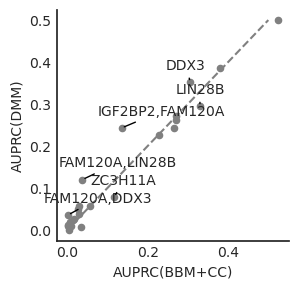

In [38]:
pairwise_compare_AUPRC(auprc_df_pivot, 'BBM+CC', 'DMM')
plt.savefig(figdir/f'AUPRC_combinatorial_BBM+CC.pdf')

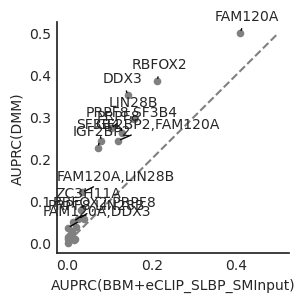

In [39]:
pairwise_compare_AUPRC(auprc_df_pivot, 'BBM+eCLIP_SLBP_SMInput', 'DMM')
plt.savefig(figdir/f'AUPRC_combinatorial_BBM+smi.pdf')

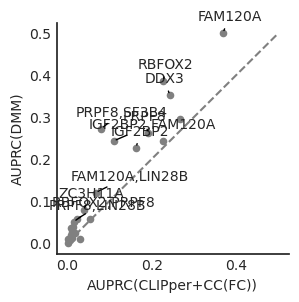

In [40]:
pairwise_compare_AUPRC(auprc_df_pivot, 'CLIPper+CC(FC)', 'DMM')
plt.savefig(figdir/f'AUPRC_combinatorial_CLIPper.pdf')

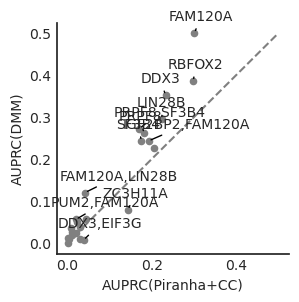

In [41]:
pairwise_compare_AUPRC(auprc_df_pivot, 'Piranha+CC', 'DMM')
plt.savefig(figdir/f'AUPRC_combinatorial_Piranha.pdf')

<Axes: xlabel='name', ylabel='AUPRC'>

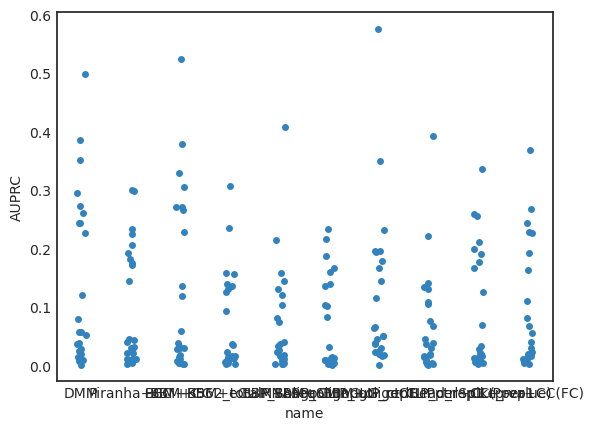

In [42]:
sns.stripplot(auprc_df, x = 'name', y = 'AUPRC')

## Binary classification: Whether is a binding site for 1 RBP

In [43]:
# window_by_rbp_score = np.matmul(mixture_weight_only, model_mean.T)
# window_by_rbp_score.columns = model_mean.index
# window_by_rbp_score.index = mixture_weight_only.index

In [44]:
def by_rbp_auprc(all_scores, goldstandard_key = 'eCLIP', subset_cols = None, figsize = (12,4)):
    ground_truth = all_scores[goldstandard_key]
    # plot ROC curve
    if subset_cols:
        to_plot = subset_cols
    else:
        to_plot = ground_truth.columns
    f, axes = plt.subplots(2 if len(to_plot)>1 else 1,
                           math.ceil(len(to_plot)/2), 
                           figsize = figsize, 
                           sharex = True, sharey = True)
    try:
        axes = axes.flatten()
    except Exception as e:
        print(e)
        axes=[axes]
    auprc_data = []
    for col, ax in zip(to_plot, axes):
        truth = ground_truth[col]
        
        ax.set_title(col)
        ax.set_ylabel('Recall')
        ax.set_xlabel('Precision')
        
        # DMM
        for name in all_scores.keys():
            if name != goldstandard_key:
                score = all_scores[name][col]
                precision, recall, thresholds = precision_recall_curve(truth, 
                                                                    score)
                auprc = auc(recall, precision)
                ax.plot(recall, precision, label = f'{name}({auprc:.2f})')
                auprc_data.append([col, auprc, name])

    ax.legend(bbox_to_anchor = (1,1.5))
    sns.despine()
    plt.tight_layout()
    
    
    return pd.DataFrame(auprc_data, 
                        columns=['RBP', 'AUPRC', 'name'])

In [45]:
[i.shape for i in all_scores.values()]

[(138498, 10),
 (138498, 10),
 (138498, 10),
 (138498, 10),
 (138498, 10),
 (138498, 10),
 (138498, 10),
 (138498, 10),
 (138498, 10),
 (138498, 10),
 (138498, 10)]

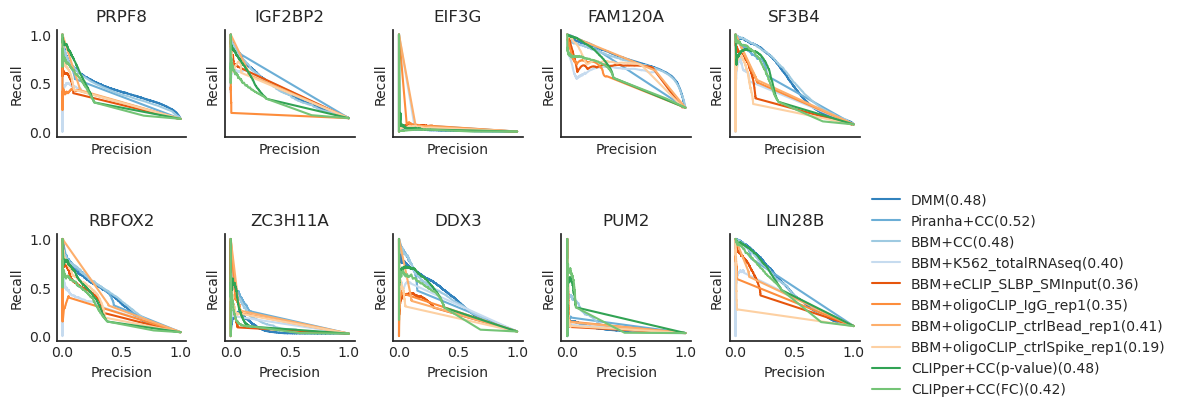

In [46]:
auprc_df_byrbp = by_rbp_auprc(all_scores)
plt.savefig(figdir/f'AUPRC_individual.pdf')

'Axes' object has no attribute 'flatten'


/scratch/hsher/33712418.tscc-mgr7.local/ipykernel_6333/4184947915.py:37: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


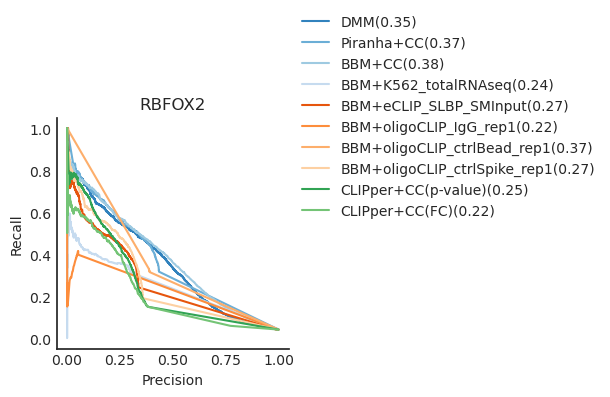

In [47]:
_=by_rbp_auprc(all_scores, subset_cols = ['RBFOX2'], figsize = (3,3))

In [48]:
auprc_df_byrbp_pivot = pd.pivot_table(auprc_df_byrbp, index = 'RBP', columns = 'name', values = 'AUPRC')

In [49]:
auprc_df_byrbp_pivot

name,BBM+CC,BBM+K562_totalRNAseq,BBM+eCLIP_SLBP_SMInput,BBM+oligoCLIP_IgG_rep1,BBM+oligoCLIP_ctrlBead_rep1,BBM+oligoCLIP_ctrlSpike_rep1,CLIPper+CC(FC),CLIPper+CC(p-value),DMM,Piranha+CC
RBP,,,,,,,,,,
DDX3,0.368902,0.316538,0.236836,0.247351,0.256080,0.192087,0.275548,0.329657,0.375118,0.339869
EIF3G,0.017997,0.090319,0.033322,0.070980,0.100312,0.027963,0.009184,0.021583,0.010595,0.035234
FAM120A,0.724185,0.588811,0.622253,0.513865,0.718508,0.643814,0.533291,0.575432,0.742977,0.643584
IGF2BP2,0.417028,0.413652,0.422301,0.166845,0.430214,0.401353,0.290638,0.348778,0.426779,0.500545
LIN28B,0.477616,0.395273,0.359921,0.350853,0.410513,0.193952,0.422380,0.481073,0.482594,0.515617
PRPF8,0.413864,0.302465,0.290086,0.295751,0.344483,0.316357,0.293851,0.330506,0.433400,0.376683
PUM2,0.117738,0.075186,0.067840,0.095596,0.092908,0.074059,0.128644,0.188481,0.067165,0.114095
RBFOX2,0.377305,0.244158,0.269372,0.223793,0.366339,0.272247,0.218533,0.253381,0.353589,0.367499
SF3B4,0.524514,0.337434,0.291023,0.376222,0.388455,0.248337,0.360809,0.383674,0.500110,0.455124


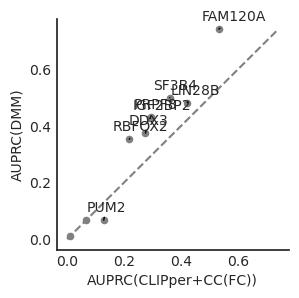

In [50]:
pairwise_compare_AUPRC(auprc_df_byrbp_pivot, 'CLIPper+CC(FC)', 'DMM')
plt.savefig(figdir/f'AUPRC_individual_DMMvsCLIPper.pdf')

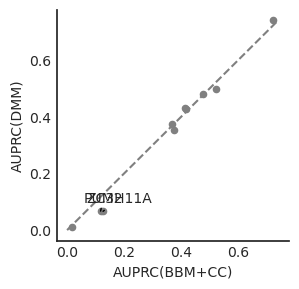

In [51]:
pairwise_compare_AUPRC(auprc_df_byrbp_pivot, 'BBM+CC', 'DMM')
plt.savefig(figdir/f'AUPRC_individual_DMMvsBBMCCr.pdf')

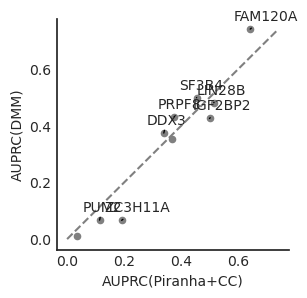

In [52]:
pairwise_compare_AUPRC(auprc_df_byrbp_pivot, 'Piranha+CC', 'DMM')
plt.savefig(figdir/f'AUPRC_individual_DMMvsPiranha.pdf')

# Motifs

In [53]:

window_bed = BedTool('/projects/ps-yeolab4/software/skipper/1.0.0/bin/skipper/annotations/gencode.v38.annotation.k562_totalrna.gt1.tiled_partition.features.tsv.gz')
window_df = pd.read_csv(window_bed.fn, sep = '\t')

pum_motif = pd.read_csv('/home/hsher/scratch/k562_window_pum2.homer.motif', sep = '\t')
pum_motif = pum_motif.loc[pum_motif['Motif Name']=='1-TGTATATA']
pum_motif['windowstrand']=pum_motif['PositionID'].map(window_df.set_index('name')['strand'])
pum_motif.dropna(inplace = True)
pum_motif = pum_motif.loc[pum_motif['Strand']==pum_motif['windowstrand']]

rbfox2_motif = pd.read_csv('/home/hsher/scratch/k562_window_rbfox2.homer.motif', sep = '\t')
rbfox2_motif = rbfox2_motif.loc[rbfox2_motif['Motif Name']=='1-TGCATG']
rbfox2_motif['windowstrand']=rbfox2_motif['PositionID'].map(window_df.set_index('name')['strand'])
rbfox2_motif.dropna(inplace = True)
rbfox2_motif = rbfox2_motif.loc[rbfox2_motif['Strand']==rbfox2_motif['windowstrand']]


In [54]:
def read_everything(rbp):
    beta = pd.read_csv(basedir / 'beta-mixture_CC'/f'{out_stem}.{rbp}.enriched_windows.tsv', sep = '\t')
    prianha =pd.read_csv(basedir/ 'comparison' / 'piranha' / 'CC'/f'{out_stem}.{rbp}.bed',
                         names = ['chr', 'start', 'sned', 'name', 'score', 'strand', 'pval', 'cov'],
                         sep = '\t')
    skipper = pd.read_csv(basedir / 'skipper_CC'/'enriched_windows'/f'{out_stem}.{rbp}.enriched_windows.tsv.gz',
                          sep = '\t')
    return beta, prianha, skipper
    

In [55]:
rbp = 'PUM2'
b,p,s = read_everything(rbp)

motif_df = pum_motif
b['is_motif']=b['name'].isin(motif_df['PositionID'])
p['is_motif']=p['name'].isin(motif_df['PositionID'])
s['is_motif']=s['name'].isin(motif_df['PositionID'])
dmm = megaoutput.loc[megaoutput[f'{out_stem}.{rbp}']].copy()
dmm['is_motif'] = dmm['name'].isin(motif_df['PositionID'])
clipper = ground_truth.loc[ground_truth[rbp]].copy()
clipper['is_motif'] = clipper.index.isin(motif_df['PositionID'])
eclip = ground_truth_skipper.loc[ground_truth_skipper[rbp]].copy()
eclip['is_motif'] = eclip.index.isin(motif_df['PositionID'])

motif_cnt = pd.concat([dmm.groupby(by = 'is_motif').count()['name'],
    b.groupby(by = 'is_motif').count()['name'],
             p.groupby(by = 'is_motif').count()['name'],
             s.groupby(by = 'is_motif').count()['name'],
             
             clipper.groupby(by = 'is_motif').count().iloc[:,0],
             eclip.groupby(by = 'is_motif').count().iloc[:,0]
            ], axis = 1)
motif_cnt.columns = ['DMM','Beta', 'Piranha', 'Skipper', 'CLIPper', 'eCLIP']

In [56]:
rbp = 'RBFOX2'
b,p,s = read_everything(rbp)
motif_df = rbfox2_motif
b['is_motif']=b['name'].isin(motif_df['PositionID'])
p['is_motif']=p['name'].isin(motif_df['PositionID'])
s['is_motif']=s['name'].isin(motif_df['PositionID'])
dmm = megaoutput.loc[megaoutput[f'{out_stem}.{rbp}']].copy()
dmm['is_motif'] = dmm['name'].isin(motif_df['PositionID'])
clipper = ground_truth.loc[ground_truth[rbp]].copy()
clipper['is_motif'] = clipper.index.isin(motif_df['PositionID'])
eclip = ground_truth_skipper.loc[ground_truth_skipper[rbp]].copy()
eclip['is_motif'] = eclip.index.isin(motif_df['PositionID'])

motif_cnt_fox2 = pd.concat([
    dmm.groupby(by = 'is_motif').count()['name'],
    b.groupby(by = 'is_motif').count()['name'],
             p.groupby(by = 'is_motif').count()['name'],
             s.groupby(by = 'is_motif').count()['name'],
             
             clipper.groupby(by = 'is_motif').count().iloc[:,0],
             eclip.groupby(by = 'is_motif').count().iloc[:,0]
            ], axis = 1)
motif_cnt_fox2.columns = ['DMM','Beta', 'Piranha', 'Skipper', 'CLIPper', 'eCLIP']


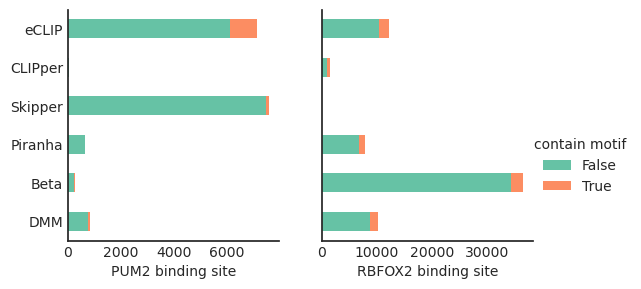

In [57]:
sns.set_palette('Set2')
f, ax = plt.subplots(1,2, sharey = True, figsize = (6,3))
motif_cnt.T.plot.barh(stacked = True, ax = ax[0], legend = False)
motif_cnt_fox2.T.plot.barh(stacked = True, ax = ax[1])
ax[0].set_xlabel('PUM2 binding site')
ax[1].set_xlabel('RBFOX2 binding site')
ax[1].legend(bbox_to_anchor = (1.5, 0.5), title = 'contain motif')
sns.despine()
plt.savefig(figdir/f'PUM2_RBFOX2_nmotif.pdf')

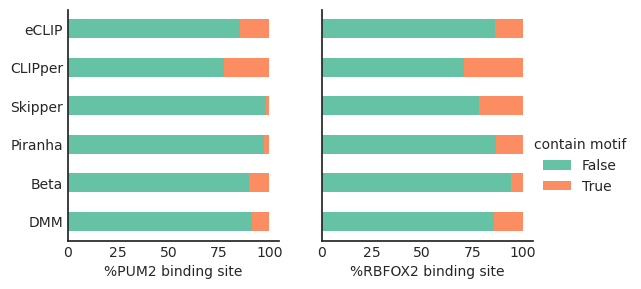

In [58]:
f, ax = plt.subplots(1,2, sharey = True, figsize = (6,3))
(100*(motif_cnt.div(motif_cnt.sum(axis = 0), axis = 1))).T.plot.barh(stacked = True, ax = ax[0], legend = False)
(100*(motif_cnt_fox2.div(motif_cnt_fox2.sum(axis = 0), axis = 1))).T.plot.barh(stacked = True, ax = ax[1])
ax[0].set_xlabel('%PUM2 binding site')
ax[1].set_xlabel('%RBFOX2 binding site')
ax[1].legend(bbox_to_anchor = (1.5, 0.5), title = 'contain motif')
sns.despine()
plt.savefig(figdir/f'PUM2_RBFOX2_precmotif.pdf')

In [59]:
motif_cnt.div(motif_cnt.sum(axis = 0), axis = 1)

,DMM,Beta,Piranha,Skipper,CLIPper,eCLIP
is_motif,,,,,,
False,0.913507,0.901575,0.972136,0.983833,0.774194,0.854624
True,0.086493,0.098425,0.027864,0.016167,0.225806,0.145376


In [60]:
motif_cnt_fox2.div(motif_cnt_fox2.sum(axis = 0), axis = 1)

,DMM,Beta,Piranha,Skipper,CLIPper,eCLIP
is_motif,,,,,,
False,0.8564,0.94075,0.868613,0.78125,0.709589,0.859086
True,0.1436,0.05925,0.131387,0.21875,0.290411,0.140914


# Shared binding site

In [61]:
def mask_output(identity_tbl):
    ''' apply softmask to non-DMM outputs for fair comparison '''
    # mask
    common_index = list(set(identity_tbl.index).intersection(set(mask.index)))
    
    identity_tbl.loc[common_index, mask.columns] = identity_tbl.loc[common_index, mask.columns] & mask # being logLR > 2 and >2*stdev
    return identity_tbl

In [62]:
def get_beta_mixture_identity_tbl(root_dir):
    identity_tbl = []
    for fname in list(root_dir.glob(f'{out_stem}*window_score.tsv')):
        libname, rbp = fname.name.split('.')[:2]
        df = pd.read_csv(fname, index_col = 0, sep = '\t')
        value = df.set_index('name')['enriched']
        value.name = rbp
        identity_tbl.append(value)
        
    identity_tbl = pd.concat(identity_tbl, axis = 1).fillna(False)
    
    
    return mask_output(identity_tbl)

In [63]:
all_identity_matrix = {}
all_identity_matrix['eCLIP']=ground_truth_skipper
all_identity_matrix['DMM']=megaoutput[anno.columns]

all_identity_matrix['CLIPper+CC']=clipper_1rep
all_identity_matrix['Piranha+CC']=mask_output(all_scores['Piranha+CC'].ge(0.95))

for ext_background in ['K562_totalRNAseq', 'eCLIP_SLBP_SMInput', 
                       'oligoCLIP_IgG_rep1', 'oligoCLIP_ctrlBead_rep1',
                       'oligoCLIP_ctrlSpike_rep1']:
    all_identity_matrix[f'BBM+{ext_background}'] = mask_output(get_beta_mixture_identity_tbl(
        basedir / f'beta-mixture_external/{ext_background}'))

In [64]:
# calculate jaccard index
def compute_jaccard_index(identity_tbl):
    ''' use jaccard index to show how much binding site overlapped between RBPs'''
    d_condense = pdist(identity_tbl.T, 'jaccard')
    d = pd.DataFrame(1-squareform(d_condense), index = identity_tbl.columns, columns = identity_tbl.columns)
    return d


list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range


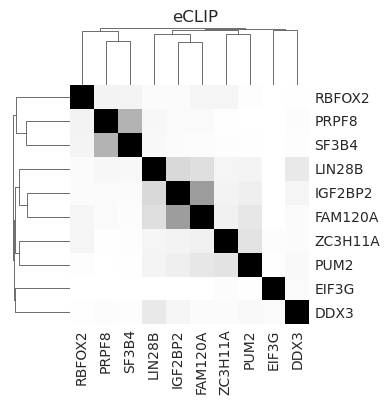

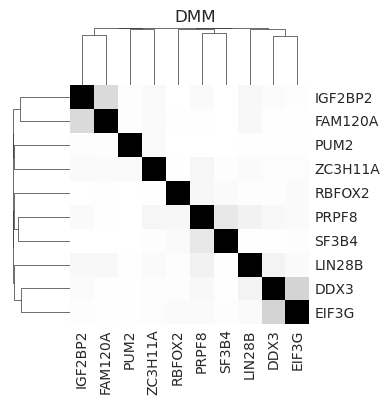

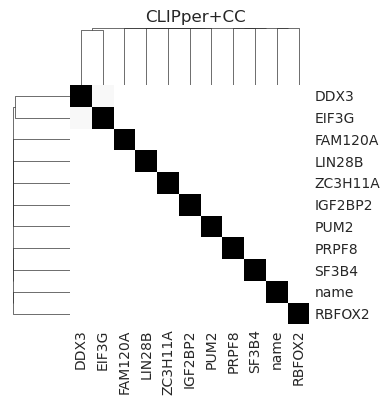

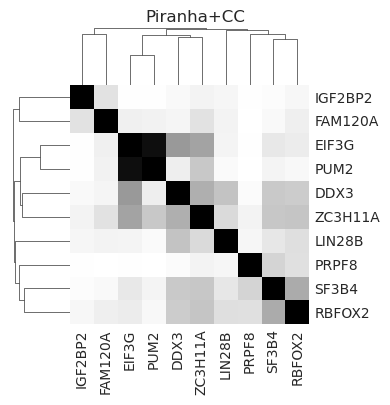

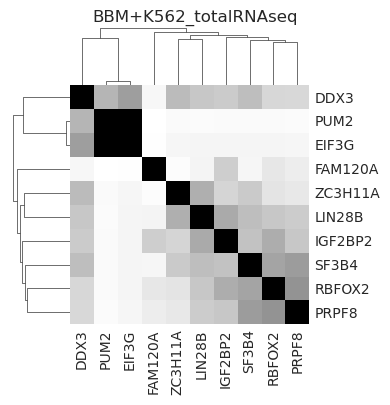

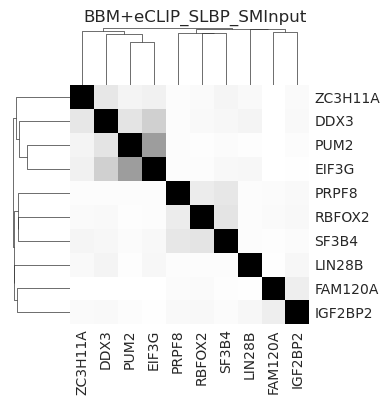

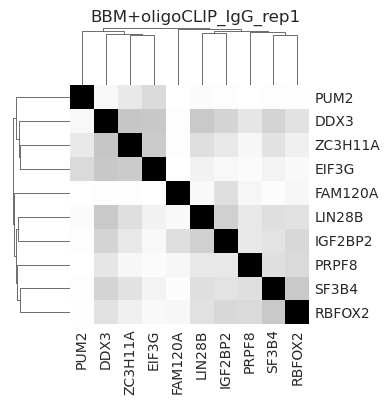

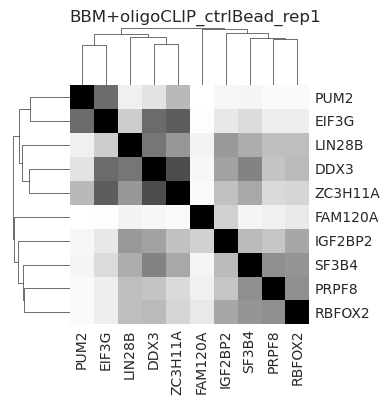

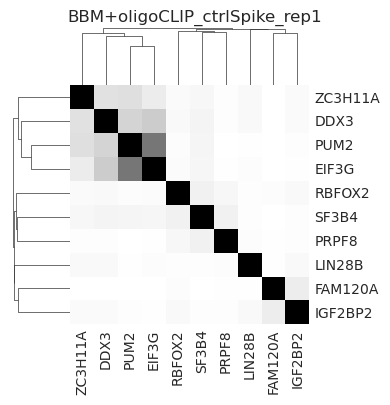

In [65]:
for key in all_identity_matrix:
    d_dmm = compute_jaccard_index(all_identity_matrix[key])
    try:
        d_dmm.index = [i.split('.')[1] for i in d_dmm.index]
        d_dmm.columns = [i.split('.')[1] for i in d_dmm.columns]
    except Exception as e:
        print(e)
    cm=sns.clustermap(d_dmm, cmap = 'Greys', metric = 'correlation', figsize = (4,4),
                vmax = 0.3)
    cm.cax.set_visible(False)
    plt.suptitle(f'{key}', y = 1)
    plt.savefig(figdir/f'jaccard_{key}.pdf')

In [66]:
[c.columns for c in all_identity_matrix.values()]

[Index(['PRPF8', 'IGF2BP2', 'EIF3G', 'FAM120A', 'SF3B4', 'RBFOX2', 'ZC3H11A',
        'DDX3', 'PUM2', 'LIN28B'],
       dtype='object'),
 Index(['K562_rep6.IGF2BP2', 'K562_rep6.RBFOX2', 'K562_rep6.PUM2',
        'K562_rep6.FAM120A', 'K562_rep6.DDX3', 'K562_rep6.ZC3H11A',
        'K562_rep6.EIF3G', 'K562_rep6.PRPF8', 'K562_rep6.LIN28B',
        'K562_rep6.SF3B4'],
       dtype='object'),
 Index(['name', 'IGF2BP2', 'PRPF8', 'SF3B4', 'DDX3', 'LIN28B', 'RBFOX2',
        'EIF3G', 'ZC3H11A', 'FAM120A', 'PUM2'],
       dtype='object'),
 Index(['SF3B4', 'IGF2BP2', 'RBFOX2', 'EIF3G', 'FAM120A', 'DDX3', 'LIN28B',
        'PUM2', 'PRPF8', 'ZC3H11A'],
       dtype='object'),
 Index(['PUM2', 'IGF2BP2', 'DDX3', 'ZC3H11A', 'EIF3G', 'LIN28B', 'RBFOX2',
        'SF3B4', 'PRPF8', 'FAM120A'],
       dtype='object'),
 Index(['DDX3', 'RBFOX2', 'PUM2', 'FAM120A', 'LIN28B', 'SF3B4', 'PRPF8',
        'ZC3H11A', 'IGF2BP2', 'EIF3G'],
       dtype='object'),
 Index(['SF3B4', 'FAM120A', 'PRPF8', 'RBFOX2', 'LIN28B

In [67]:
window_df

,chrom,start,end,name,score,strand,feature_id,feature_bin,feature_type_top,feature_types,gene_name,gene_id,transcript_ids,gene_type_top,transcript_type_top,gene_types,transcript_types
0,chr1,629639,629733,1,0,+,1,1,EXON_PSEUDO,EXON_PSEUDO,MTND2P28,ENSG00000225630.1,ENST00000457540.1,unprocessed_pseudogene,unprocessed_pseudogene,unprocessed_pseudogene,unprocessed_pseudogene
1,chr1,629733,629828,2,0,+,1,2,EXON_PSEUDO,EXON_PSEUDO,MTND2P28,ENSG00000225630.1,ENST00000457540.1,unprocessed_pseudogene,unprocessed_pseudogene,unprocessed_pseudogene,unprocessed_pseudogene
2,chr1,629828,629923,3,0,+,1,3,EXON_PSEUDO,EXON_PSEUDO,MTND2P28,ENSG00000225630.1,ENST00000457540.1,unprocessed_pseudogene,unprocessed_pseudogene,unprocessed_pseudogene,unprocessed_pseudogene
3,chr1,629923,630018,4,0,+,1,4,EXON_PSEUDO,EXON_PSEUDO,MTND2P28,ENSG00000225630.1,ENST00000457540.1,unprocessed_pseudogene,unprocessed_pseudogene,unprocessed_pseudogene,unprocessed_pseudogene
4,chr1,630018,630113,5,0,+,1,5,EXON_PSEUDO,EXON_PSEUDO,MTND2P28,ENSG00000225630.1,ENST00000457540.1,unprocessed_pseudogene,unprocessed_pseudogene,unprocessed_pseudogene,unprocessed_pseudogene
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5926992,chrM,14403,14488,5926993,0,-,641141,4,CDS,CDS:EXON_MRNA,MT-ND6,ENSG00000198695.2,ENST00000361681.2,protein_coding,protein_coding,protein_coding,protein_coding
5926993,chrM,14488,14573,5926994,0,-,641141,5,CDS,CDS:EXON_MRNA,MT-ND6,ENSG00000198695.2,ENST00000361681.2,protein_coding,protein_coding,protein_coding,protein_coding
5926994,chrM,14573,14673,5926995,0,-,641142,1,CDS_START,CDS_START:CDS:EXON_MRNA,MT-ND6,ENSG00000198695.2,ENST00000361681.2,protein_coding,protein_coding,protein_coding,protein_coding
5926995,chrM,14673,14742,5926996,0,-,641143,1,EXON_SMALL,EXON_SMALL,MT-TE,ENSG00000210194.1,ENST00000387459.1,Mt_tRNA,Mt_tRNA,Mt_tRNA,Mt_tRNA


In [79]:

def plot_pairs(all_identity_matrix, pairs, ax=None, legend = False):
    all_counts = []
    for key in all_identity_matrix.keys():
        df = all_identity_matrix[key]
        try:
            subset = df.loc[df[pairs].all(axis = 1)]
        except Exception as e:
            print(e)
            subset = df.loc[df[[f'{out_stem}.{rbp}' for rbp in pairs]].all(axis = 1)]
                    
        cnt = window_df.loc[window_df['name'].isin(subset.index),'feature_type_top'].value_counts()
        cnt.name = key
        all_counts.append(cnt)
    all_counts = pd.concat(all_counts, axis = 1).fillna(0).sort_index()

    
    return all_counts 

In [110]:
combinatorial = [i for i in collapsed_cluster_anno.values() if len(i)>1]

all_counts = []
for pair in combinatorial:
             

    counts = plot_pairs(all_identity_matrix, pair, ax = ax)
    counts['pair']=','.join(pair)
    all_counts.append(counts)

all_counts = pd.concat(all_counts,axis = 0).fillna(0)



"None of [Index(['PRPF8', 'SF3B4'], dtype='object')] are in the [columns]"
"None of [Index(['PRPF8', 'LIN28B'], dtype='object')] are in the [columns]"
"None of [Index(['ZC3H11A', 'PRPF8'], dtype='object')] are in the [columns]"
"None of [Index(['DDX3', 'EIF3G'], dtype='object')] are in the [columns]"
"None of [Index(['FAM120A', 'LIN28B'], dtype='object')] are in the [columns]"
"None of [Index(['FAM120A', 'PRPF8'], dtype='object')] are in the [columns]"
"None of [Index(['FAM120A', 'ZC3H11A'], dtype='object')] are in the [columns]"
"None of [Index(['FAM120A', 'DDX3'], dtype='object')] are in the [columns]"
"None of [Index(['PUM2', 'ZC3H11A'], dtype='object')] are in the [columns]"
"None of [Index(['PUM2', 'FAM120A'], dtype='object')] are in the [columns]"
"None of [Index(['RBFOX2', 'PRPF8'], dtype='object')] are in the [columns]"
"None of [Index(['RBFOX2', 'PRPF8', 'SF3B4'], dtype='object')] are in the [columns]"
"None of [Index(['RBFOX2', 'FAM120A'], dtype='object')] are in the [columns

/scratch/hsher/33712418.tscc-mgr7.local/ipykernel_6333/1140747098.py:16: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


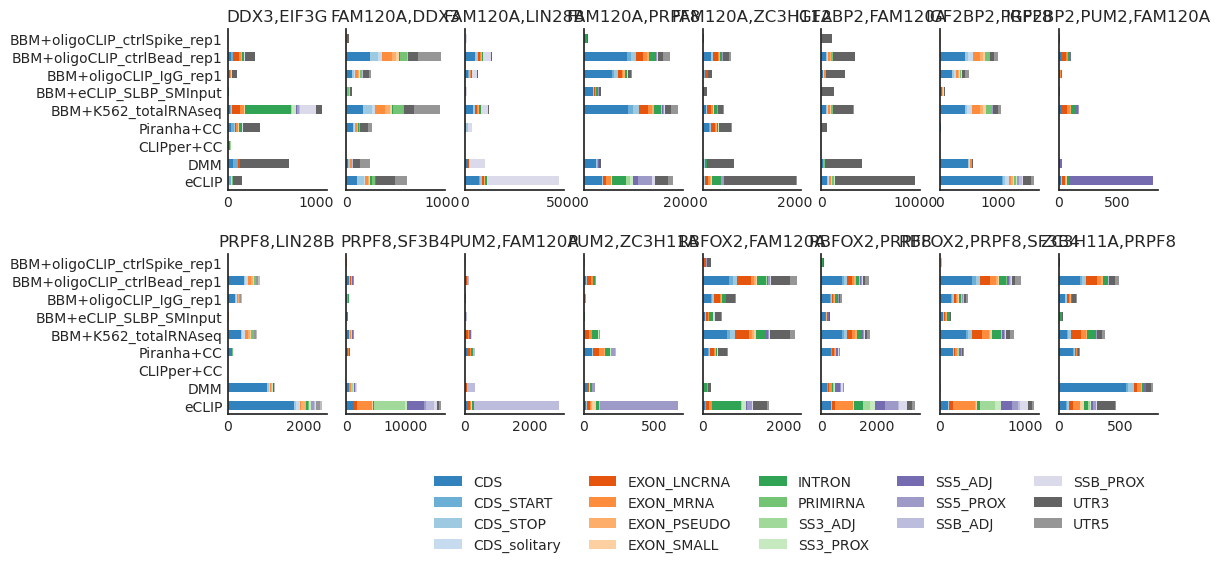

In [111]:

f, axes = plt.subplots(math.ceil(len(combinatorial)/8),8, figsize = (12,5), sharey = True)
axes = axes.flatten()
sns.set_palette('tab20c')
for ax, (name, group) in zip(axes, all_counts.groupby(by = 'pair')):
    
    if 'CDS_solitary' not in group.index:
        group.loc['CDS_solitary']=0
    group.sort_index().drop('pair', axis = 1).T.plot.barh(stacked = True, ax = ax, legend = False)
    ax.set_title(name)
    sns.despine()
    
    
ax.legend(bbox_to_anchor = (1, -0.3), ncol = 5)
plt.subplots_adjust(
                    hspace=0.4)
plt.tight_layout()

plt.savefig(figdir/f'combinatorial_feature_types.pdf')



In [86]:
all_counts.columns

Index(['eCLIP', 'DMM', 'CLIPper+CC', 'Piranha+CC', 'BBM+K562_totalRNAseq',
       'BBM+eCLIP_SLBP_SMInput', 'BBM+oligoCLIP_IgG_rep1',
       'BBM+oligoCLIP_ctrlBead_rep1', 'BBM+oligoCLIP_ctrlSpike_rep1', 'pair'],
      dtype='object')

In [104]:
set(eclip_counts.columns)-set(all_counts.index)

{'RBP', 'name'}